# Libraries

In [2]:
import glob
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from PIL import Image
import os.path as osp
import glob

from tensorflow.keras.preprocessing.image import img_to_array, load_img
import os

import torch
import torchvision
import torchvision.transforms as transforms

from torchvision.datasets import ImageFolder
from matplotlib import pyplot as plt
import numpy as np
from sklearn.utils import shuffle
from skimage import io, filters

import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [3]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

In [6]:
DEVICE = 'mps'
EPOCHS=20
LR = 0.003
BATCH_SIZE = 16
IMG_SIZE = 256

# Data

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# !unzip "/content/drive/MyDrive/Final_Project/circularMask.zip" -d "/content/dataset"
# !unzip "/content/drive/MyDrive/Final_Project/image.zip" -d "/content/dataset"

In [ ]:
mask_dir = '/home/bcca/Desktop/Akshit/dataset/circularMask'
image_dir = '/home/bcca/Desktop/Akshit/dataset/image'

# List the files in each directory
mask_files = [os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith('.png')]
image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.png')]

# Sort files to maintain order, if necessary
mask_files.sort()
image_files.sort()

# Create the DataFrame
df = pd.DataFrame({
    'masks': mask_files,
    'images': image_files
})


In [ ]:
df.head()

In [ ]:
row = df.iloc[1]
image_path=row.images
mask_path = row.masks
image  = cv2.imread(image_path)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)/255.0

In [ ]:
train_df,valid_df= train_test_split(df,test_size = 0.2,random_state = 42)

In [ ]:
import albumentations as A

In [ ]:
def get_train_augs():
      return A.Compose([
      A.Resize(IMG_SIZE,IMG_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ])

def get_valid_augs():
      return A.Compose([
      A.Resize(IMG_SIZE,IMG_SIZE)
  ])

# Load the Dataset into Dataloader

In [ ]:
class SegmentationDataset(Dataset):
    def __init__(self,df,augmentation):
        self.df = df
        self.augmentation = augmentation
    def __len__(self):
        return len(self.df)
    def __getitem__(self,idx):
        row = self.df.iloc[idx]
        image_path=row.images
        mask_path = row.masks
        image = cv2.imread(image_path)
        image = cv2.resize(image,(IMG_SIZE,IMG_SIZE))

        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE) #SHAPE OF (h,w,c)
        mask = cv2.resize(mask,(IMG_SIZE,IMG_SIZE))
        mask = np.expand_dims(mask , axis = -1)

    if self.augmentation:
        data = self.augmentation(image = image ,mask = mask)
        image = data['image']
        mask = data['mask']

    #(h,w,c)--->(c,h,w) pytorch format
    image = np.transpose(image,(2,0,1)).astype(np.float32)
    mask = np.transpose(mask,(2,0,1)).astype(np.float32)

    image = torch.Tensor(image)/255.0
    mask = torch.round(torch.Tensor(mask))/255.0
    return image , mask

In [ ]:
trainset = SegmentationDataset(train_df,get_train_augs())
validset = SegmentationDataset(valid_df,get_valid_augs())

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(trainset,batch_size = BATCH_SIZE ,shuffle =True)
validloader = DataLoader(validset,batch_size = BATCH_SIZE,shuffle = True)

# Data Visualization

In [ ]:
noisy_imgs, clean_imgs = next(iter(trainloader))

In [ ]:
noisy_img_np = noisy_imgs[0].numpy().transpose(1, 2, 0)
clean_img_np = clean_imgs[0].numpy().transpose(1, 2, 0)

# Plotting the noisy and clean images
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the noisy image
axs[0].imshow(noisy_img_np, cmap='gray')
axs[0].set_title('Noisy Image')
axs[0].axis('off')

# Plot the clean image
axs[1].imshow(clean_img_np, cmap='gray')
axs[1].set_title('Clean Image')
axs[1].axis('off')

plt.show()

In [ ]:
print("total no. of batches in trainloader",len(trainloader))
print("total no. of batches in validloader",len(validloader))

In [ ]:
for image,mask in(trainloader):
    break
print("One batch image shape",(image.shape))
print("One batch mask shape",(mask.shape))

# Model

In [3]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [4]:
ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel,self).__init__()
        self.arc=smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels=3,
        classes = 1,
        activation = None

    )
        

        def forward(self,images,masks = None):
            logits = self.arc(images)
            if masks != None: s 
            loss1 = DiceLoss(mode= 'binary')(logits,masks)
            loss2 = nn.BCEWithLogitsLoss()(logits,masks)
                return logits,loss1 +loss2
    return logits

In [7]:
model =   SegmentationModel()
model.to(DEVICE);

# Loss Function

In [ ]:
def calculate_iou(pred_mask, true_mask):
    pred_mask = pred_mask.detach().cpu().squeeze(0).numpy()  # Move to CPU and convert to NumPy array
    true_mask = true_mask.detach().cpu().squeeze(0).numpy()  # Move to CPU and convert to NumPy array

    intersection = np.logical_and(true_mask, pred_mask).sum()
    union = np.logical_or(true_mask, pred_mask).sum()

    iou = intersection / union if union > 0 else 0.0  # Avoid division by zero
    return iou


# Train Function

In [ ]:
def train_fn(data_loader, model, optimizer):
    model.train()
    total_loss = 0.0
    total_iou = 0.0
    total_samples = 0

    for images, masks in tqdm(data_loader):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()

        logits = model(images)
        preds = (torch.sigmoid(logits) > 0.5).float()

        # Calculate IoU for each batch
        for i in range(len(images)):
            total_iou += calculate_iou(preds[i], masks[i].squeeze())

        # Calculate loss
        logits,loss = model(images,masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_samples += images.size(0)

    avg_loss = total_loss / len(data_loader)
    avg_iou = total_iou / total_samples
    return avg_loss, avg_iou


# Evaluation Function

In [ ]:
def eval_fn(data_loader, model):
    model.eval()
    total_loss = 0.0
    total_iou = 0.0
    total_samples = 0

    for images, masks in tqdm(data_loader):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        with torch.no_grad():
            logits = model(images)
            preds = (torch.sigmoid(logits) > 0.5).float()

            # Calculate IoU for each batch
            for i in range(len(images)):
                total_iou += calculate_iou(preds[i], masks[i].squeeze())

        # Calculate loss for each batch
        logits, loss = model(images, masks)
        total_loss += loss.item()
        total_samples += images.size(0)

    avg_loss = total_loss / len(data_loader)
    avg_iou = total_iou / total_samples
    return avg_loss, avg_iou


# Train Model

In [ ]:
loss_train=[]
loss_valid=[]
train_iou=[]
valid_iou=[]
iteration=[]

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
best_valid_loss = np.Inf


idx_to_segment = 18

for epoch in range(EPOCHS):
    train_loss, iou_train = train_fn(trainloader, model, optimizer)
    valid_loss, iou_valid = eval_fn(validloader, model)

    loss_train.append(train_loss)
    loss_valid.append(valid_loss)
    train_iou.append(iou_train)
    valid_iou.append(iou_valid)
    iteration.append(epoch + 1)
    
    torch.save(model.state_dict(), 'best_model.pt')

    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'best_model.pt')
        print("Saved model")
        best_valid_loss = valid_loss

    print(f"Epoch: {epoch + 1} Train Loss: {train_loss} Valid Loss: {valid_loss} IOU Train: {iou_train} IOU Valid: {iou_valid}")

    # Segment the chosen image after every epoch
    image, mask = validset[idx_to_segment]
    logits_mask = model(image.unsqueeze(0).to(DEVICE))
    pred_mask = torch.sigmoid(logits_mask)
    pred_mask = (pred_mask > 0.5)*1.0
    
    
     

    seg_path = f'/home/bcca/Desktop/Akshit/segmented_image/segmented_epoch_{epoch + 1}.png'
    img_pth = f'/home/bcca/Desktop/Akshit/image/img.png'
    torchvision.utils.save_image(pred_mask, seg_path)
    torchvision.utils.save_image(image.unsqueeze(0).to(DEVICE), img_pth)
    



In [ ]:
torch.save(model.state_dict(),'best_model.pt')

# Results

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(8,3))

# Plotting loss
axs[0].plot(iteration, loss_train, label='Training Loss')
axs[0].plot(iteration, loss_valid, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Iterations')
axs[0].set_xlabel('Iterations')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plotting IoU
axs[1].plot(iteration, train_iou, label='Training IoU')
axs[1].plot(iteration, valid_iou, label='Validation IoU')
axs[1].set_title('Training and Validation IoU over Iterations')
axs[1].set_xlabel('Iterations')
axs[1].set_ylabel('IoU')
axs[1].legend()

plt.tight_layout()
plt.show()


# Testing on Test Dataset

In [ ]:
idx = 23

#here we are going to use valid set as test set
model.load_state_dict(torch.load('/Users/akshitdhillon/Documents/M.Tech/4Apr2024/best_model_1.pt'))
image,mask = validset[idx]
logits_mask = model(image.to(DEVICE).unsqueeze(0))
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask>0.5)*1.0

In [ ]:
image.shape

In [ ]:
def show_image(image,mask,pred_image = None):

    if pred_image == None:

        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')

        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')

    elif pred_image != None :

        f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10,5))

        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')

        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')

        ax3.set_title('MODEL OUTPUT')
        ax3.imshow(pred_image.permute(1,2,0).squeeze(),cmap = 'gray')



In [ ]:
show_image(image,mask,pred_mask.detach().cpu().squeeze(0))

# Testing on Custom Dataset

In [8]:
import torch
from torchvision import transforms
import numpy as np


In [9]:
img_path='/Users/akshitdhillon/Documents/M.Tech/Project/M.T.P._Colab/test0.jpg'
img=cv2.imread(img_path)

In [10]:
model.load_state_dict(torch.load('/Users/akshitdhillon/Documents/M.Tech/4Apr2024/best_model_1.pt',map_location=torch.device('cpu')))

<All keys matched successfully>

In [11]:
# Resize the Image according to Our Model Input 

img_tensor = torch.from_numpy(img).permute(2, 0, 1).float() 

resize_transform = transforms.Resize((256, 256))

img_resized = resize_transform(img_tensor)

# Check the size, it should be torch.Size([3, 256, 256])
print(img_resized.size())


torch.Size([3, 256, 256])


In [12]:
logits_mask = model(img_resized.to(DEVICE).unsqueeze(0))
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask>0.5)*1.0

In [13]:
pred_mask.shape

torch.Size([1, 1, 256, 256])

In [14]:
def test_show(image,pred_image = None):

    

        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        image = image.permute(1, 2, 0).numpy()
        ax1.set_title('IMAGE')
        ax1.imshow(image.astype('uint8'),cmap = 'gray')

        ax2.set_title('Segmentation')
        ax2.imshow(pred_image.permute(1,2,0).squeeze(),cmap = 'gray')




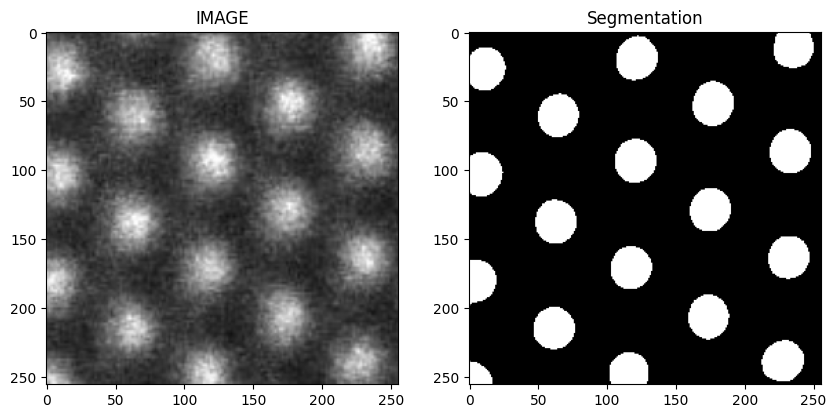

In [15]:
test_show(img_resized,pred_mask.detach().cpu().squeeze(0))

# Guassian Denoising

In [16]:
img1_path= '/Users/akshitdhillon/Documents/M.Tech/Project/M.T.P._Colab/test0.jpg'
img1=cv2.imread(img1_path)

In [17]:
def sc(image):
    
    img_tensor = torch.from_numpy(image).permute(2, 0, 1).float() 
    resize_transform = transforms.Resize((256, 256))
    img_resized = resize_transform(img_tensor)
    return img_resized


In [18]:
img1= sc(img1)

In [19]:
img1.shape

torch.Size([3, 256, 256])

In [20]:
def seg(img):
    logits_mask = model(img.to(DEVICE).unsqueeze(0))
    pred_mask = torch.sigmoid(logits_mask)
    pred_mask = (pred_mask>0.5)*1.0
    return pred_mask
    
def gs(img, sigma):
    segmented_img= seg(img)
    gaussian = filters.gaussian(segmented_img.squeeze().cpu().numpy(), sigma)
    return gaussian, segmented_img.detach().cpu().squeeze(0)


In [21]:
gs, seg= gs(img1,8)

In [22]:
def show(image,gs, pred_image = None):

    

        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,5))
        image = image.permute(1, 2, 0).numpy()
        ax1.set_title('IMAGE')
        ax1.imshow(image.astype('uint8'),cmap = 'gray')

        ax2.set_title('TEM_simulated')
        ax2.imshow(gs, cmap='gray')

        ax3.set_title('Segmentation')
        ax3.imshow(pred_image.permute(1,2,0).squeeze(),cmap = 'gray')

        
    

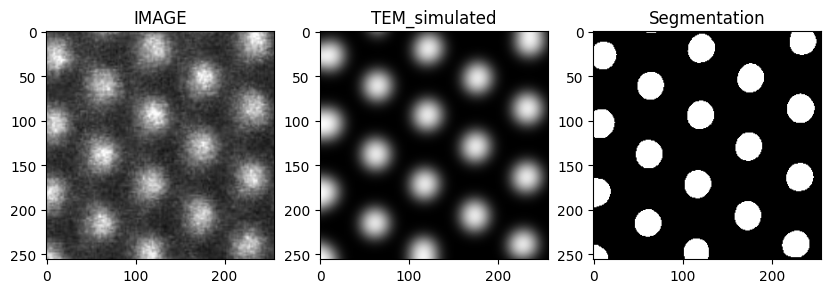

In [23]:
show(img1, gs, seg)

# Higher Dimension Image

In [104]:
img2path='/Users/akshitdhillon/Documents/M.Tech/Project/M.T.P._Colab/full_TEM_image_1.jpg'
orginial= cv2.imread(img2path)

In [111]:
from PIL import Image
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


def divide_image(image_path):
    
    original_image = Image.open(image_path)

    
    resize_transform = transforms.Resize((256, 256))
    resized_image = resize_transform(original_image)

    
    width, height = resized_image.size

    
    part_width = width // 4
    part_height = height // 4

    
    part_regions = []
    part_tensors = [] 

    
    for i in range(4):
        for j in range(4):
            region = (j * part_width, i * part_height, (j + 1) * part_width, (i + 1) * part_height)
            part_regions.append(region)
            part = resized_image.crop(region)

           
            transform_to_tensor = transforms.Compose([
                transforms.Resize((256, 256)),
                transforms.ToTensor()
            ])
            part_tensor = transform_to_tensor(part)
            part_tensors.append(part_tensor)

    return part_tensors, part_regions


def reassemble_parts(part_tensors, part_regions):
    
    with torch.no_grad():
        part_logits = []
        for part_tensor in part_tensors:
            part_tensor = part_tensor.to(DEVICE).unsqueeze(0)
            logits_mask = model(part_tensor)
            part_logits.append(logits_mask)

    
    reassembled_logits = []
    for i in range(0, len(part_logits), 4):
        row_logits = torch.cat(part_logits[i:i + 4], dim=3)
        reassembled_logits.append(row_logits)
    reassembled_logits = torch.cat(reassembled_logits, dim=2)

    
    pred_mask = torch.sigmoid(reassembled_logits)
    pred_mask = (pred_mask > 0.5).float()

    return pred_mask


# Crop the Image
part_tensors, part_regions = divide_image(image_path)

# Attached all cropped image together
reassembled_mask = reassemble_parts(part_tensors, part_regions)


reassembled_image = transforms.ToPILImage()(reassembled_mask.squeeze())

# Display the reassembled image
# plt.imshow(reassembled_image, cmap='gray')
# plt.title('Rejoined Image')
# plt.axis('off')
# plt.show()
segmentation=np.array(reassembled_image)

In [102]:
Simulated = filters.gaussian(reassembled_image, 5)

In [125]:
Simulated=np.array(Simulated)
Simulated.shape

(1024, 1024)

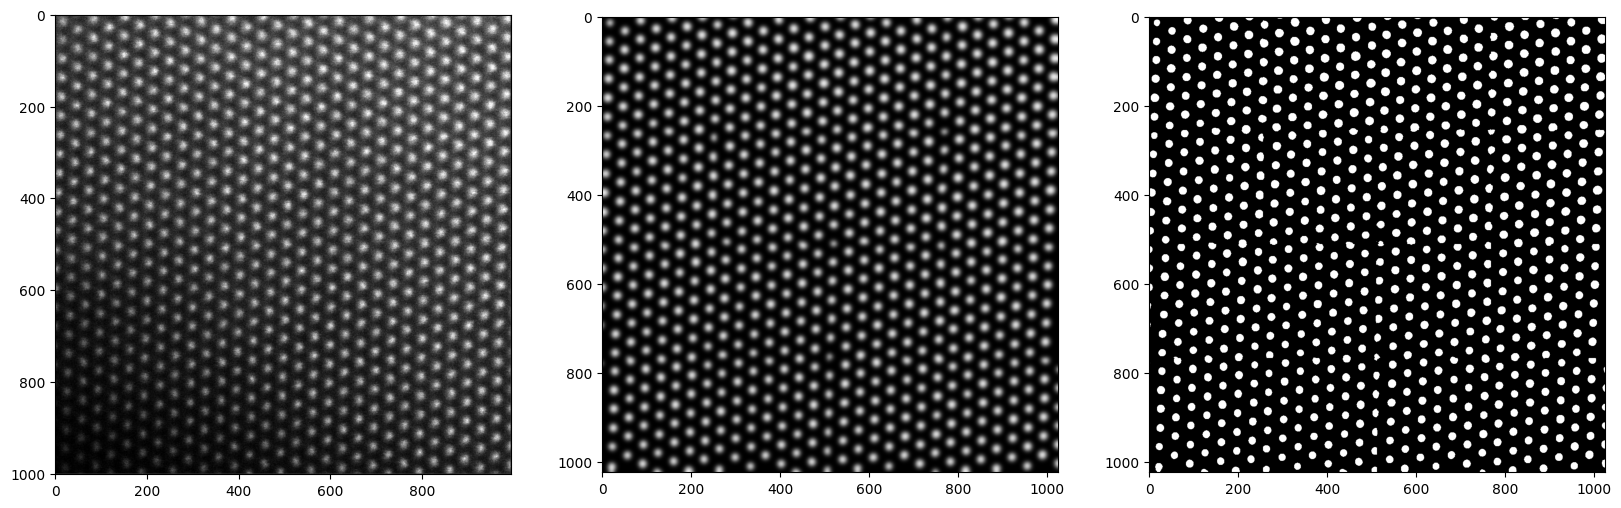

In [126]:
fig, (a1, a2, a3) = plt.subplots(1, 3, figsize=(20, 10))
a1.imshow(orginial, cmap='gray')
a2.imshow(Simulated, cmap='gray')
a3.imshow(segmentation, cmap='gray')


# Localization

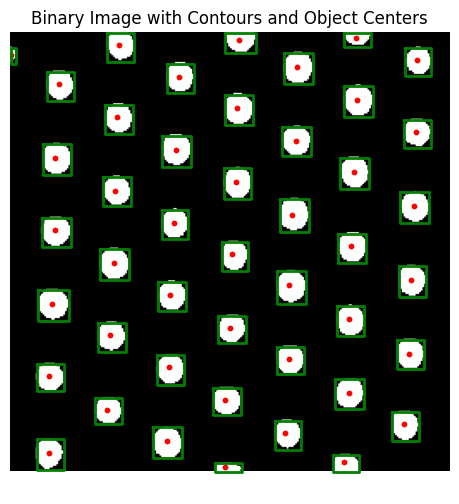

In [43]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


binary_image = seg.copy()


if binary_image.ndim > 2:
    binary_image = cv2.cvtColor(binary_image, cv2.COLOR_BGR2GRAY)
binary_image = cv2.convertScaleAbs(binary_image)


contours, hierarchy = cv2.findContours(binary_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Calculate the center of each object
centers = []
for contour in contours:
    # Calculate the moments of the contour
    moments = cv2.moments(contour)
    
    # Check if the contour has an area
    if moments['m00'] != 0:
        # Calculate the center of the contour
        center = (int(moments['m10'] / moments['m00']), int(moments['m01'] / moments['m00']))
        centers.append(center)

# Plotting the binary image with contours
plt.figure(figsize=(8, 6))
plt.imshow(binary_image, cmap='gray')

# Plot contours on the image
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    plt.plot([x, x + w, x + w, x, x], [y, y, y + h, y + h, y], 'g-', linewidth=2)

# Plot the centers on the image
plt.scatter([c[0] for c in centers], [c[1] for c in centers], c='red', s=10)

# Add a title and show the plot
plt.title('Binary Image with Contours and Object Centers')
plt.axis('off')
plt.show()


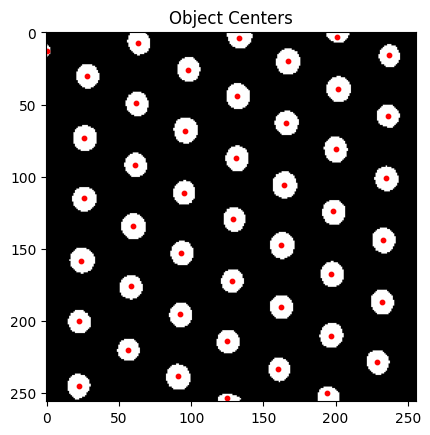

In [38]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the binary image
image = seg

# Convert the image to 8-bit unsigned single-channel format
image = cv2.convertScaleAbs(image)

# Find contours in the image
contours, hierarchy = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Calculate the center of each object
centers = []
for contour in contours:
    # Calculate the moments of the contour
    moments = cv2.moments(contour)
    
    # Check if the contour has an area
    if moments['m00'] != 0:
        # Calculate the center of the contour
        center = (int(moments['m10'] / moments['m00']), int(moments['m01'] / moments['m00']))
        centers.append(center)

# Convert the binary image to a NumPy array
image_np = np.array(image)

# Display the image using matplotlib
plt.imshow(image_np, cmap='gray')

# Plot the centers on the image
plt.scatter([c[0] for c in centers], [c[1] for c in centers], c='red', s=10)

# Add a title and show the plot
plt.title('Object Centers')
plt.show()

Distance between the centers of two lines: 70.18
Distance between the centers of two lines: 38.08


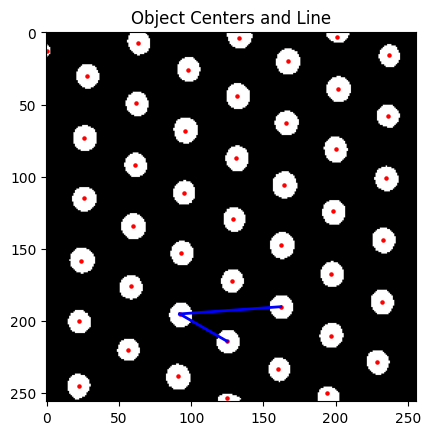

In [47]:
plt.imshow(image_np, cmap='gray')


plt.scatter([c[0] for c in centers], [c[1] for c in centers], c='red', s=5)

line1_center = centers[10]
line2_center = centers[11]

line3_center = centers[7]
distance1 = np.sqrt((line1_center[0] - line2_center[0])**2 + (line1_center[1] - line2_center[1])**2)
distance2 = np.sqrt((line1_center[0] - line3_center[0])**2 + (line1_center[1] - line3_center[1])**2)

print(f'Distance between the centers of two lines: {distance1:.2f}')
print(f'Distance between the centers of two lines: {distance2:.2f}')

plt.plot([line1_center[0], line3_center[0]], [line1_center[1], line3_center[1]], c='blue', linewidth=2)

# Draw a line between the centers of two lines
plt.plot([line1_center[0], line2_center[0]], [line1_center[1], line2_center[1]], c='blue', linewidth=2)

# Add a title and show the plot
plt.title('Object Centers and Line')
plt.show()

In [48]:

vector1= np.array(line1_center) - np.array(line2_center)
vector2= np.array(line1_center) - np.array(line3_center)

dot_product = np.dot(vector1, vector2)
magnitude_vector1 = np.linalg.norm(vector1)
magnitude_vector2 = np.linalg.norm(vector2)

# Calculate the cosine of the angle between the vectors
cosine_angle = dot_product / (magnitude_vector1 * magnitude_vector2)

# Calculate the angle in radians and then convert to degrees
angle_rad = np.arccos(cosine_angle)
angle_deg = np.degrees(angle_rad)

print(f'Angle between the two vectors: {angle_deg:.2f} degrees')


Angle between the two vectors: 34.02 degrees
